# Sandbox environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gym
import agents
import environment
import utils 

## REINFORCE algorithm

In [2]:
from importlib import reload
reload(agents)
reload(environment)
reload(utils)

<module 'utils' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/utils.py'>

In [3]:
def play_episode(agent, env, return_states=False, greedy=True):
    # Reset environment (start of an episode)
    state = env.reset()
    rewards = []
    log_probs = []
    done = []
    
    if return_states:
        states = [state]
    while True:
        state = np.array([state])
        action, log_prob = agent.get_action(state, return_log = True, greedy=greedy)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        if return_states:
            states.append(new_state)
       
        rewards.append(reward)
        log_probs.append(log_prob)
        done.append(terminal)
        
        if terminal:
            break
            
        state = new_state
       
    rewards = np.array(rewards)
    log_probs = np.array(log_probs)
    done = np.array(done)
    
    if return_states:
        return rewards, log_probs, np.array(states), done
    else:
        return rewards, log_probs, done

In [4]:
def train_sandbox(n_episodes = 100, lr = 0.01, gamma = 0.99, greedy=False):
    # Create environment
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
    observation_space = 10*10
    action_space = 4
    # Init agent
    agent = agents.DiscretePolicyGrad(observation_space, action_space, lr, gamma, project_dim=16)
    performance = []
    losses = []
    for e in range(n_episodes):
        #print("\nEpisode %d"%(e+1))
        rewards, log_probs, _ = play_episode(agent, env, greedy=greedy)
        #print('play_episode executed')
        performance.append(np.sum(rewards))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.2f"%(e+1, np.mean(performance[-10:])))
        
        #print("rewards: ", rewards)
        #print("log_probs: ", log_probs)
        loss = agent.update(rewards, log_probs)
        #print('update loss executed')
        losses.append(loss)
    return agent, np.array(performance), np.array(losses)

In [ ]:
%%time
trained_agentPG, cumulative_rewardPG, lossesPG = train_sandbox(n_episodes = 500, lr=0.01, gamma=0.98)

In [ ]:
%matplotlib notebook
utils.render(trained_agentPG)
%matplotlib inline

# A2C

In [ ]:
from importlib import reload
reload(agents)
reload(environment)
reload(utils)

In [48]:
def play_episode_A2C(agent, env, greedy=True, return_states=False, update_online=True):
    # Reset environment (start of an episode)
    state = env.reset()
    rewards = []
    log_probs = []
    done = []
    
    if return_states:
        states = [state]
        
    while True:
        state = np.array([state])
        action, log_prob = agent.get_action(state, return_log = True)
        log_probs.append(log_prob)
        new_state, reward, terminal, info = env.step(action) 
        done.append(terminal)
        if return_states:
            states.append(new_state)
            
        rewards.append(reward)
        if update_online:
            agent.update(reward, log_prob, state, new_state, terminal)

        if terminal:
            break
        state = new_state
        
    if return_states:
        return np.array(rewards), log_probs, np.array(states), np.array(done)
    else:
        return rewards, log_probs

In [ ]:
def train_sandbox_A2C_v0(n_episodes = 100, lr_actor = 1e-1, lr_critic = 1e-3, gamma = 0.99, greedy=False):
    # Create environment
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
    observation_space = 10*10
    action_space = 4
    # Init agent
    agent = agents.A2C_v0(observation_space, action_space, lr_actor, lr_critic, gamma, discrete=True, project_dim=16)
    performance = []
    
    for e in range(n_episodes):
        rewards, _ = play_episode_A2C(agent, env, return_states=False, greedy=greedy)
        
        performance.append(np.sum(rewards))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.2f"%(e+1, np.mean(performance[-10:])))

    return agent, np.array(performance)

In [ ]:
%%time
trained_agentA2C, cumulative_rewardA2C = train_sandbox_A2C_v0(n_episodes = 500, gamma=0.99)

In [ ]:
%matplotlib notebook
utils.render(trained_agentA2C)
%matplotlib inline

# A2C updating after every trajectory

In [ ]:
from importlib import reload
reload(agents)
reload(environment)
reload(utils)

In [ ]:
def train_sandbox_A2C_v1(n_episodes = 100, lr=1e-2, gamma = 0.99, greedy=False):
    # Create environment
    env = environment.Sandbox(5, 5, [0,0], [4,4], max_steps=50)
    observation_space = 10*10
    action_space = 4
    # Init agent
    agent = agents.A2C_v1(observation_space, action_space, lr, gamma, discrete=True, project_dim=16)
    performance = []
    
    for e in range(n_episodes):
        rewards, log_probs, states, done = play_episode_A2C(agent, env, return_states=True, greedy=greedy, update_online=False)
        states = states.reshape(1,-1)
        rewards = rewards.reshape(1,-1)
        agent.update(rewards, log_probs, states, done)
        performance.append(np.sum(rewards))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.2f"%(e+1, np.mean(performance[-10:])))

    return agent, np.array(performance)

In [ ]:
%%time
trained_agentA2C_1, cumulative_rewardA2C_1 = train_sandbox_A2C_v1(n_episodes = 500, gamma=0.99)

In [ ]:
%matplotlib notebook
utils.render(trained_agentA2C_1, x=5, y=5, goal=[4,4])
%matplotlib inline

# Critic analysis

**Idea:** to see if there is any error in the critic's code or if it works properly, we can use an optimal policy to gather trajectories and see if the critic learns from them the real value of the states under an optimal policy.

We have two ways in which the critic's target can be computed:
- Temporal Difference (TD) learning: $V(s) \approx \gamma V(s') + r(s,a)$
- Monte Carlo (MC) learning: $V(s) \approx \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'}$

The first one can be very unstable by its nature, but in this simple taks should converge anyway.
I'm going to try both of them.

## Optimal policy (hardcoded)
Use method get_optimal_action of the environment.

In [ ]:
from importlib import reload
reload(agents)
reload(environment)
reload(utils)

In [ ]:
%matplotlib notebook
utils.render(x=5, y=5, goal=[4,4])
%matplotlib inline

### TD Critic Agent

In [ ]:
from networks import DiscreteCritic

In [ ]:
class CriticAgentTD():
    def __init__(self, observation_space, lr, gamma, project_dim=8):
        self.gamma = gamma
        self.lr = lr
        self.critic = DiscreteCritic(observation_space, project_dim)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=lr)
        
    def forward(self, state):
        state = torch.from_numpy(state)
        return self.critic(state)
    
    def update(self, rewards, states, done):
        rewards = torch.tensor(rewards) 
        old_states = torch.tensor(states[:-1]).view(1,-1)
        new_states = torch.tensor(states[1:]).view(1,-1)
        done = torch.LongTensor(done.astype(int))
        loss = self.update_critic(rewards, new_states, old_states, done)
        return loss
        
    def update_critic(self, rewards, new_states, old_states, done):
        # Predictions
        V_pred = self.critic(old_states).squeeze()
        #print("V_pred.shape ", V_pred.shape)
        # Targets
        V_trg = self.critic(new_states).squeeze()
        #print("V_trg.shape ", V_trg.shape)
        V_trg = (1-done)*self.gamma*V_trg + rewards
        #print("V_trg.shape ", V_trg.shape)
        # MSE loss
        loss = torch.sum((V_pred - V_trg)**2)
        # backprop and update
        self.critic_optim.zero_grad()
        loss.backward()
        self.critic_optim.step()
        return loss.item()

In [ ]:
def play_optimal(env):
    state = env.reset(random_init = True)
    #print("Initial state: ", env.initial)
    rewards = []
    done = []
    states = [state]
    
    while True:
        action = env.get_optimal_action()
        new_state, reward, terminal, info = env.step(action) 
        states.append(new_state)
        rewards.append(reward)
        done.append(terminal)
        
        if terminal:
            break
            
        state = new_state
    
    return np.array(rewards), np.array(states), np.array(done)

In [ ]:
def train_critic_TD(n_episodes = 100, lr = 0.01, gamma = 0.99):
    # Create environment
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
    observation_space = 10*10
    critic = CriticAgentTD(observation_space, lr, gamma)
    losses = []
    for e in range(n_episodes):
        rewards, states, done = play_optimal(env)
        loss = critic.update(rewards, states, done)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return critic, losses

In [ ]:
G = 0.99
critic_TD, losses_TD = train_critic_TD(1000, lr=1e-2, gamma=G)

In [6]:
def plot_loss(losses, x='', y='', t='', xlog=False, ylog=False):
    episodes = np.arange(len(losses)) + 1
    plt.figure(figsize=(8,6))
    plt.plot(episodes, losses)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.title(t, fontsize=16)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

In [ ]:
x = "Number of episodes"
y = "Squared error of the prediction [log]"
t = "Critic trained through optimal policy and TD"
plot_loss(losses_TD, x, y, t, ylog=True)

In [ ]:
def get_real_value_map(env, gamma):
    distances = np.zeros((env.boundary[0], env.boundary[1] ))
    for x in range(env.boundary[0]):
        for y in range(env.boundary[1]):
            d = env.dist_to_goal([x,y])
            distances[x,y] = d
    distances = distances.flatten() -1
    real_values = gamma**distances
    real_values[-1] = 1
    return real_values.reshape(env.boundary[0], env.boundary[1])

In [ ]:
def value_map(critic, env, gamma):
    states = np.arange(env.boundary[0]*env.boundary[1]).reshape(1,-1)
    values = critic.forward(states).squeeze()
    values = values.detach().numpy().reshape(env.boundary[0], env.boundary[1])
    
    plt.figure(figsize=(15,6))

    plt.subplot(121)
    values[-1,-1] = 1
    plt.imshow(values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Value map", fontsize=16)
    plt.colorbar()
    
    real_values = get_real_value_map(env, gamma)
    plt.subplot(122)
    #plt.imshow(values-real_values)
    plt.imshow(real_values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Real values", fontsize=16)
    plt.colorbar()
    
    plt.figure(figsize=(7,6))
    diff = values-real_values
    diff[-1,-1] = 0
    plt.imshow(diff)
    #plt.imshow(real_values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Difference from real value", fontsize=16)
    plt.colorbar()
    

In [ ]:
env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
value_map(critic_TD, env, gamma = G)

### MC Critic Agent

In [49]:
class CriticAgentMC():
    def __init__(self, observation_space, lr, gamma, project_dim=8):
        self.gamma = gamma
        self.lr = lr
        self.critic = DiscreteCritic(observation_space, project_dim)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=lr)
        
    def forward(self, state):
        state = torch.from_numpy(state)
        return self.critic(state)
    
    def update(self, rewards, states, done):
        #rewards = torch.tensor(rewards) 
        
        old_states = torch.tensor(states[:-1]).view(1,-1)
        new_states = torch.tensor(states[1:]).view(1,-1)
        #done = torch.LongTensor(done.astype(int))
        loss = self.update_critic(rewards, old_states)
        return loss
        
    def update_critic(self, rewards, old_states):
        # Predictions
        V_pred = self.critic(old_states).squeeze()
        #print("V_pred.shape ", V_pred.shape)
        # Discount factors
        Gamma = np.array([self.gamma**i for i in range(rewards.shape[0])])
        # reverse everything to use cumsum in right order, then reverse again
        Gt = np.cumsum(rewards[::-1]*Gamma[::-1])[::-1]
        # Rescale so that present reward is never discounted
        discounted_rewards =  Gt/Gamma
        dr = torch.tensor(discounted_rewards).float()    #.to(self.device)
        # MSE loss
        loss = torch.sum((V_pred - dr)**2)
        # backprop and update
        self.critic_optim.zero_grad()
        loss.backward()
        self.critic_optim.step()
        return loss.item()

In [16]:
def train_critic_MC(n_episodes = 100, lr = 0.01, gamma = 0.99):
    # Create environment
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
    observation_space = 10*10
    critic = CriticAgentMC(observation_space, lr, gamma)
    losses = []
    for e in range(n_episodes):
        rewards, states, done = play_optimal(env)
        loss = critic.update(rewards, states, done)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return critic, losses

In [17]:
critic_MC, losses_MC = train_critic_MC(1000, lr=1e-2)

NameError: name 'DiscreteCritic' is not defined

In [ ]:
x = "Number of episodes"
y = "Critic loss"
t = "Critic with MC estimation and optimal policy"
plot_loss(losses_MC, x, y, t, ylog=True)

In [ ]:
env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
value_map(critic_MC, env, gamma = 0.99)

## Confrontation TD-MC

In [ ]:
episodes = np.arange(len(losses_MC)) + 1
plt.figure(figsize=(8,6))
plt.plot(episodes, losses_MC, label='MC')
plt.plot(episodes, losses_TD, label='TD')
plt.xlabel("Number of episodes", fontsize=16)
plt.ylabel("Squared error of the prediction", fontsize=16)
plt.title("Critic trained through optimal policy", fontsize=16)
plt.yscale("log")
plt.legend(fontsize=13)
plt.show()

In [ ]:
def TD_vs_MC(TD_critic, MC_critic, env):
    states = np.arange(env.boundary[0]*env.boundary[1]).reshape(1,-1)
    values_TD = TD_critic.forward(states).squeeze()
    values_TD = values_TD.detach().numpy().reshape(env.boundary[0], env.boundary[1])

    values_MC = MC_critic.forward(states).squeeze()
    values_MC = values_MC.detach().numpy().reshape(env.boundary[0], env.boundary[1])
    
    plt.figure(figsize=(15,6))

    plt.subplot(121)
    values_TD[-1,-1] = 1
    plt.imshow(values_TD, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title("Value map TD", fontsize=16)
    plt.colorbar()

    plt.subplot(122)
    #plt.imshow(values-real_values)
    values_MC[-1,-1] = 1
    plt.imshow(values_MC, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title("Value map MC", fontsize=16)
    plt.colorbar()


In [ ]:
env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
TD_vs_MC(critic_TD, critic_MC, env)

# Checking Actor implementation with optimal critic

**Idea:** substitute a critic with an hardcoded version that knows the optimal value of each cell.

## TD actor
Using Temporal Difference estimation of the advantage with the optimal critic.

In [50]:
from networks import DiscreteActor
from torch.distributions import Categorical

In [59]:
class ActorAgentTD():
    def __init__(self, observation_space, action_space, lr, gamma, project_dim=8):
        self.gamma = gamma
        self.lr = lr
        self.actor = DiscreteActor(observation_space, action_space, project_dim)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=lr)
        
    def get_action(self, state, return_log=False, **kwargs):
        state = torch.from_numpy(state)
        log_probs = self.actor(state)
        dist = torch.exp(log_probs)
        probs = Categorical(dist)
        action =  probs.sample().item()
        if return_log:
            return action, log_probs.view(-1)[action]
        else:
            return action
    
    def critic(self, state, env):
        """Implements optimal critic given the sandbox environment."""
        #print("State.shape: ", state.shape)
        distances = []
        for s in state:
            s_decoded = [s//env.boundary[0], s%env.boundary[1]]
            #print("\n\tState %d decoded in (%d, %d)"%(s, s_decoded[0], s_decoded[1]))
            d = env.dist_to_goal(s_decoded)
            #print("\tGoal in (%d,%d)"%(env.goal[0], env.goal[1]))
            #print("\tDistance from goal: ", d)
            distances.append(d)
        distances = np.array(distances) -1
        values = torch.tensor(self.gamma**distances).float()
        #print("Distances: ", distances)
        #print("Values: ", values,'\n')
        return values
        
    
    def update(self, rewards, log_probs, states, done, env):
        rewards = torch.tensor(rewards) 
        old_states = states[:-1]
        new_states = states[1:]
        done = torch.LongTensor(done.astype(int))
        log_probs = torch.stack(log_probs)
        loss = self.update_actor(rewards, log_probs, new_states, old_states, done, env)
        return loss
        
    def update_actor(self, rewards, log_probs, new_states, old_states, done, env):
        # Get values from critic
        V_old = self.critic(old_states, env)
        V_new = self.critic(new_states, env)
        # Compute advantage as value(new_s) + reward - value(old_s)
        A = (1.-done)*V_new + rewards - V_old
        # Compute - gradient
        policy_gradient = - log_probs*A
        #print("policy_gradient ", policy_gradient.shape)
        # Use it as loss
        policy_grad = torch.sum(policy_gradient)
        # backprop and update
        self.actor_optim.zero_grad()
        policy_grad.backward()
        self.actor_optim.step()
        return policy_grad.item()


In [60]:
def train_actor_TD(n_episodes = 100, lr = 1e-2, gamma = 0.99):
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=100)
    observation_space = 10*10
    action_space = 4
    actor = ActorAgentTD(observation_space, action_space, lr, gamma)
    
    losses = []
    for e in range(n_episodes):
        rewards, log_probs, states, done = play_episode_A2C(actor, env, return_states=True, update_online=False)
        loss = actor.update(rewards, log_probs, states, done, env)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return actor, losses

In [61]:
actor_TD, actor_loss_TD = train_actor_TD(1000)

Episode 10 - loss: -12.1437
Episode 20 - loss: -7.0883
Episode 30 - loss: -7.3059
Episode 40 - loss: -2.4117
Episode 50 - loss: -1.4741
Episode 60 - loss: -0.8905
Episode 70 - loss: -1.0756
Episode 80 - loss: -0.3705
Episode 90 - loss: -0.8270
Episode 100 - loss: 0.0000
Episode 110 - loss: -0.5204
Episode 120 - loss: -0.2768
Episode 130 - loss: -0.4006
Episode 140 - loss: -0.0080
Episode 150 - loss: -0.0012
Episode 160 - loss: 0.0014
Episode 170 - loss: 0.0012
Episode 180 - loss: 0.0094
Episode 190 - loss: -0.0021
Episode 200 - loss: -0.0032
Episode 210 - loss: -0.0076
Episode 220 - loss: -0.0028
Episode 230 - loss: -0.0035
Episode 240 - loss: -0.0037
Episode 250 - loss: 0.0007
Episode 260 - loss: -0.0044
Episode 270 - loss: 0.0006
Episode 280 - loss: 0.0006
Episode 290 - loss: 0.0006
Episode 300 - loss: -0.0041
Episode 310 - loss: -0.0082
Episode 320 - loss: -0.0103
Episode 330 - loss: -0.0036
Episode 340 - loss: 0.0004
Episode 350 - loss: 0.0071
Episode 360 - loss: -0.0045
Episode 37

<IPython.core.display.Javascript object>


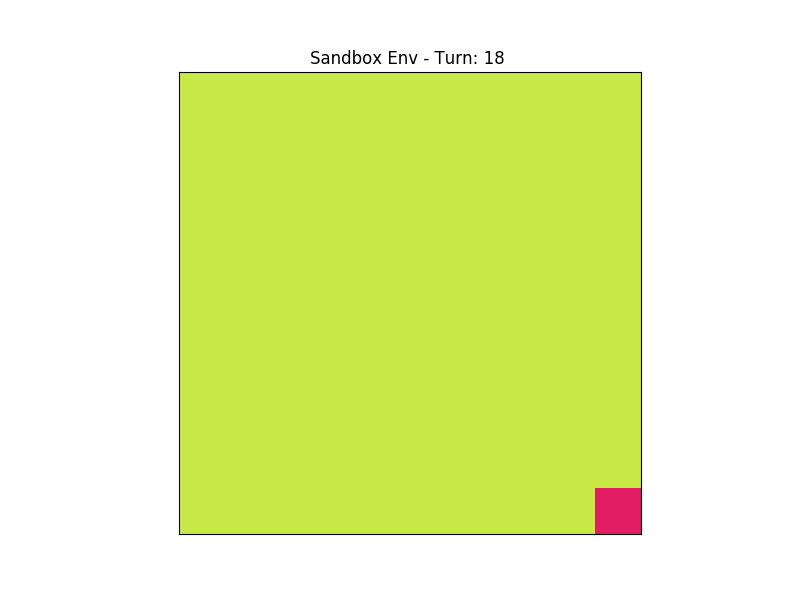

In [62]:
%matplotlib notebook
utils.render(actor_TD, x=10, y=10, goal=[9,9])
%matplotlib inline

### Actor-Critic with MC estimation

In [63]:
import ActorCritic
reload(ActorCritic)

<module 'ActorCritic' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/ActorCritic.py'>

In [64]:
def train_sandbox_A2C_MC(n_episodes = 100, lr = 1e-2, gamma = 0.99):
    # Create environment
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=100)
    observation_space = 10*10
    action_space = 4
    # Init agent
    agent = ActorCritic.DiscreteA2C(observation_space, action_space, lr, gamma, project_dim=16)
    performance = []
    critic_losses = []
    actor_losses = []
    
    for e in range(n_episodes):
        rewards, log_probs, states, done = play_episode_A2C(agent, env, return_states=True, update_online=False)
        critic_loss, actor_loss = agent.update(rewards, log_probs, states, done)
        critic_losses.append(critic_loss)
        actor_losses.append(actor_loss)
        performance.append(np.sum(rewards))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.2f"%(e+1, np.mean(performance[-10:])))

    return agent, np.array(performance), np.array(critic_losses), np.array(actor_losses)

In [65]:
MC_A2C, MC_reward, critic_loss, actor_loss = train_sandbox_A2C_MC(1000)

Episode 10 - reward: -15.20
Episode 20 - reward: -11.40
Episode 30 - reward: -7.70
Episode 40 - reward: -2.90
Episode 50 - reward: -5.30
Episode 60 - reward: -3.10
Episode 70 - reward: -1.60
Episode 80 - reward: -5.50
Episode 90 - reward: -1.60
Episode 100 - reward: -1.60
Episode 110 - reward: -1.70
Episode 120 - reward: -1.30
Episode 130 - reward: -2.30
Episode 140 - reward: -0.60
Episode 150 - reward: -0.70
Episode 160 - reward: 0.80
Episode 170 - reward: 1.00
Episode 180 - reward: 0.20
Episode 190 - reward: 1.00
Episode 200 - reward: 1.00
Episode 210 - reward: 0.70
Episode 220 - reward: 0.90
Episode 230 - reward: 1.00
Episode 240 - reward: 1.00
Episode 250 - reward: 1.00
Episode 260 - reward: 1.00
Episode 270 - reward: 1.00
Episode 280 - reward: 1.00
Episode 290 - reward: 0.70
Episode 300 - reward: 1.00
Episode 310 - reward: 1.00
Episode 320 - reward: 0.90
Episode 330 - reward: 1.00
Episode 340 - reward: 1.00
Episode 350 - reward: 1.00
Episode 360 - reward: 1.00
Episode 370 - reward

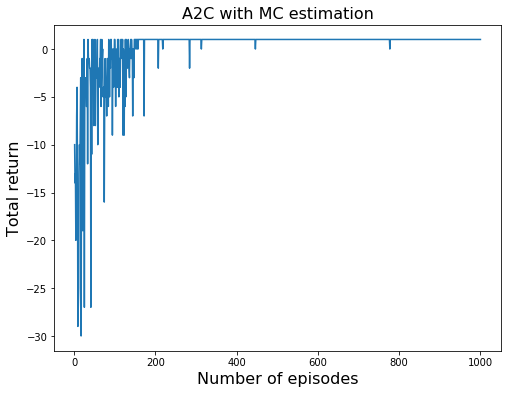

In [66]:
x = "Number of episodes"
y = "Total return"
t = "A2C with MC estimation"
plot_loss(MC_reward, x, y, t)

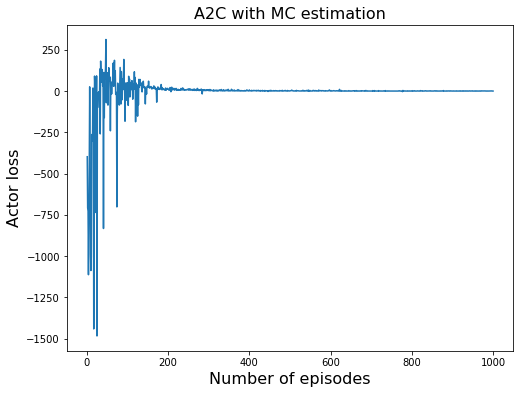

In [67]:
x = "Number of episodes"
y = "Actor loss"
t = "A2C with MC estimation"
plot_loss(actor_loss, x, y, t)

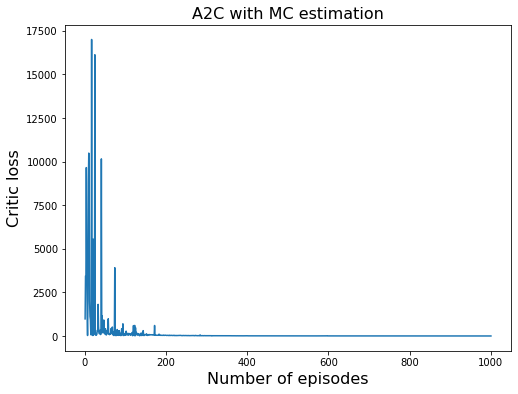

In [68]:
x = "Number of episodes"
y = "Critic loss"
t = "A2C with MC estimation"
plot_loss(critic_loss, x, y, t)

<IPython.core.display.Javascript object>


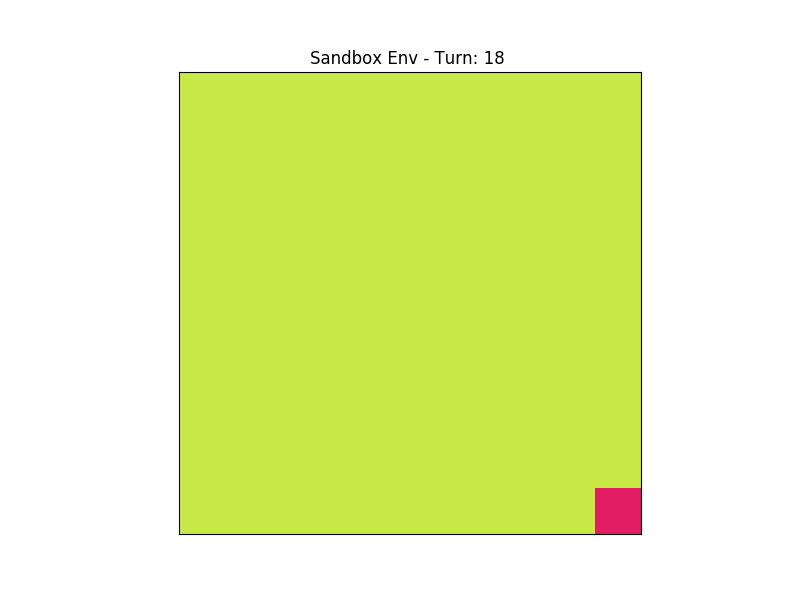

In [69]:
%matplotlib notebook
utils.render(MC_A2C, x=10, y=10, goal=[9,9])
%matplotlib inline